# LSTM Experiments


## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import InputLayer, TextVectorization, Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Read Data

In [3]:
BASE_PATH = r"C:\Users\joehi\Documents\Work\Uni - Year 4\COMP61332\Coursework\dataset\data\json"
# FILE = r"\train.json"
FILE = r"\dev.json"

df = pd.read_json(BASE_PATH + FILE)

In [4]:
# Define constants
EMEDDING_SIZE = 300
LSTM_UNITS = 128

VOCAB_SIZE = 20000
MAX_LEN = 100
NUM_LABELS = df["relation"].nunique()

EPOCHS = 10
BATCH_SIZE = 128
VAL_SPLIT = 0.2
LR = 0.001

In [5]:
labels = df["relation"].unique()

sentences = []
relation_ids = []
# for sentence in df['token'].values:
for i, row in df.iterrows():
    sentences.append(" ".join(row["token"]))
    relation_ids.append(np.where(labels == row["relation"])[0][0])

df.insert(4, "sentence", sentences, True)
df.insert(3, "relation_id", relation_ids, True)

X = df["sentence"].values
y = tf.one_hot(df["relation_id"].values, NUM_LABELS)

df.head(5)

,id,docid,relation,relation_id,token,sentence,subj_start,subj_end,obj_start,obj_end,subj_type,obj_type,stanford_pos,stanford_ner,stanford_head,stanford_deprel
0,e7798fb926b9403cfcd2,APW_ENG_20101103.0539,per:title,0,"[At, the, same, time, ,, Chief, Financial, Off...","At the same time , Chief Financial Officer Dou...",8,9,12,12,PERSON,TITLE,"[IN, DT, JJ, NN, ,, NNP, NNP, NNP, NNP, NNP, M...","[O, O, O, O, O, O, O, O, PERSON, PERSON, O, O,...","[4, 4, 4, 12, 12, 10, 10, 10, 10, 12, 12, 0, 1...","[case, det, amod, nmod, punct, compound, compo..."
1,e779865fb96bbbcc4ca4,APW_ENG_20080229.1401.LDC2009T13,no_relation,1,"[U.S., District, Court, Judge, Jeffrey, White,...",U.S. District Court Judge Jeffrey White in mid...,17,18,4,5,PERSON,PERSON,"[NNP, NNP, NNP, NNP, NNP, NNP, IN, NNP, VBD, D...","[LOCATION, O, O, O, PERSON, PERSON, O, O, O, O...","[6, 6, 6, 6, 6, 9, 8, 6, 0, 11, 9, 13, 11, 20,...","[compound, compound, compound, compound, compo..."
2,e7798ae9c0adbcdc81e7,APW_ENG_20090707.0488,per:city_of_death,2,"[PARIS, 2009-07-07, 11:07:32, UTC, French, med...",PARIS 2009-07-07 11:07:32 UTC French media ear...,9,9,0,0,PERSON,CITY,"[NNP, CD, CD, NNP, NNP, NNS, RBR, VBD, IN, NNP...","[LOCATION, TIME, TIME, TIME, MISC, O, O, O, O,...","[6, 6, 6, 6, 6, 8, 8, 0, 16, 16, 10, 10, 12, 1...","[compound, nummod, nummod, compound, compound,..."
3,e779865fb9bddb4eccbc,LTW_ENG_20070522.0147.LDC2009T13,no_relation,1,"[The, current, holdings, of, Blackstone-operat...",The current holdings of Blackstone-operated fu...,13,14,1,1,ORGANIZATION,DATE,"[DT, JJ, NNS, IN, JJ, NNS, VBP, NNP, NNP, ,, N...","[O, DATE, O, O, MISC, O, O, ORGANIZATION, ORGA...","[3, 3, 7, 6, 6, 3, 0, 9, 7, 9, 12, 9, 9, 15, 9...","[det, amod, nsubj, case, amod, nmod, ROOT, com..."
4,e779865fb97262ce4da3,eng-NG-31-108589-8120474,no_relation,1,[http://groups.yahoo.com/group/aspartameNM/mes...,http://groups.yahoo.com/group/aspartameNM/mess...,27,27,53,53,ORGANIZATION,PERSON,"[NN, NN, IN, DT, JJ, JJ, NN, IN, NN, NN, :, NN...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[2, 0, 7, 7, 7, 7, 2, 10, 10, 7, 2, 13, 2, 13,...","[compound, ROOT, case, det, amod, amod, nmod, ..."


In [6]:
for i in range(len(labels)):
    print(i, "\t", labels[i])

0 	 per:title
1 	 no_relation
2 	 per:city_of_death
3 	 org:shareholders
4 	 per:employee_of
5 	 per:origin
6 	 per:date_of_death
7 	 org:top_members/employees
8 	 per:identity
9 	 org:city_of_branch
10 	 per:religion
11 	 per:city_of_birth
12 	 org:alternate_names
13 	 org:website
14 	 per:spouse
15 	 per:cause_of_death
16 	 org:members
17 	 org:stateorprovince_of_branch
18 	 per:countries_of_residence
19 	 per:siblings
20 	 per:stateorprovinces_of_residence
21 	 per:parents
22 	 org:country_of_branch
23 	 per:age
24 	 per:date_of_birth
25 	 per:cities_of_residence
26 	 per:country_of_death
27 	 per:country_of_birth
28 	 per:children
29 	 org:member_of
30 	 per:stateorprovince_of_birth
31 	 per:schools_attended
32 	 per:charges
33 	 org:founded
34 	 org:founded_by
35 	 per:stateorprovince_of_death
36 	 org:dissolved
37 	 per:other_family
38 	 org:political/religious_affiliation
39 	 org:number_of_employees/members


In [7]:
d = df.iloc[2]
print(d, "\n\n")

for i in range(len(d["token"])):
    print(d["token"][i].ljust(15), d["stanford_pos"][i], d["stanford_ner"][i].ljust(10), d["stanford_head"][i], d["stanford_deprel"][i], sep="\t")

id                                              e7798ae9c0adbcdc81e7
docid                                          APW_ENG_20090707.0488
relation                                           per:city_of_death
relation_id                                                        2
token              [PARIS, 2009-07-07, 11:07:32, UTC, French, med...
sentence           PARIS 2009-07-07 11:07:32 UTC French media ear...
subj_start                                                         9
subj_end                                                           9
obj_start                                                          0
obj_end                                                            0
subj_type                                                     PERSON
obj_type                                                        CITY
stanford_pos       [NNP, CD, CD, NNP, NNP, NNS, RBR, VBD, IN, NNP...
stanford_ner       [LOCATION, TIME, TIME, TIME, MISC, O, O, O, O,...
stanford_head      [6, 6, 6, 6, 6,

## Define LSTM Model

The codeblock below implements a Bidirectional LSTM model. The design of this is adapted from https://medium.com/southpigalle/simple-relation-extraction-with-a-bi-lstm-model-part-1-682b670d5e11.

In [8]:
class RelExLSTM(Model):
    def __init__(self, embedding_size, lstm_units, vocab_size, num_labels, max_len, vocab, use_vocab=False):
        super(RelExLSTM, self).__init__()

        self.input_layer = InputLayer(name="Input", input_shape=(1,), dtype=tf.string)

        if use_vocab:
            self.vectoriser = TextVectorization(name="TextVectorisation", vocabulary=vocab, output_sequence_length=max_len)
        else:
            self.vectoriser = TextVectorization(name="TextVectorisation", max_tokens=vocab_size, output_sequence_length=max_len)
            self.vectoriser.adapt(vocab)
        self.embedding = Embedding(vocab_size, embedding_size, input_length=max_len, name="Embedding")
        self.lstm = Bidirectional(LSTM(lstm_units, dropout=0.7, recurrent_dropout=0.7), name="BidirectionalLSTM")
        self.dense = Dense(num_labels, activation='softmax', name="FullyConnected")

    def call(self, inputs):
        x = self.input_layer(inputs)
        x = self.vectoriser(x)
        x = self.embedding(x)
        x = self.lstm(x)
        y = self.dense(x)
        return y

model = RelExLSTM(
    embedding_size=EMEDDING_SIZE,
    lstm_units=LSTM_UNITS,
    vocab_size=VOCAB_SIZE,
    num_labels=NUM_LABELS,
    max_len=MAX_LEN,
    vocab=X,
    use_vocab=False
)

model.build((1,))
model.compile(optimizer=Adam(learning_rate=LR), loss=CategoricalCrossentropy(), metrics=["acc"])
model.summary()

Model: "rel_ex_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 1)]               0         
                                                                 
 TextVectorisation (TextVec  multiple                  0         
 torization)                                                     
                                                                 
 Embedding (Embedding)       multiple                  6000000   
                                                                 
 BidirectionalLSTM (Bidirec  multiple                  439296    
 tional)                                                         
                                                                 
 FullyConnected (Dense)      multiple                  10280     
                                                                 
Total params: 6449576 (24.60 MB)
Trainable params: 6449

In [9]:
model.fit(X, y, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VAL_SPLIT)

Epoch 1/10
123/123 [==============================] - 106s 762ms/step - loss: 1.9398 - acc: 0.5697 - val_loss: 1.5641 - val_acc: 0.5974
Epoch 2/10
123/123 [==============================] - 89s 726ms/step - loss: 1.5331 - acc: 0.5916 - val_loss: 1.4774 - val_acc: 0.5895
Epoch 3/10
123/123 [==============================] - 85s 694ms/step - loss: 1.3787 - acc: 0.6055 - val_loss: 1.4477 - val_acc: 0.5918
Epoch 4/10
123/123 [==============================] - 82s 669ms/step - loss: 1.2706 - acc: 0.6202 - val_loss: 1.4950 - val_acc: 0.5655
Epoch 5/10
123/123 [==============================] - 81s 658ms/step - loss: 1.1753 - acc: 0.6373 - val_loss: 1.4338 - val_acc: 0.5839
Epoch 6/10
123/123 [==============================] - 81s 659ms/step - loss: 1.0876 - acc: 0.6533 - val_loss: 1.4423 - val_acc: 0.5885
Epoch 7/10
123/123 [==============================] - 80s 647ms/step - loss: 1.0182 - acc: 0.6701 - val_loss: 1.4396 - val_acc: 0.5752
Epoch 8/10
123/123 [==============================] - 

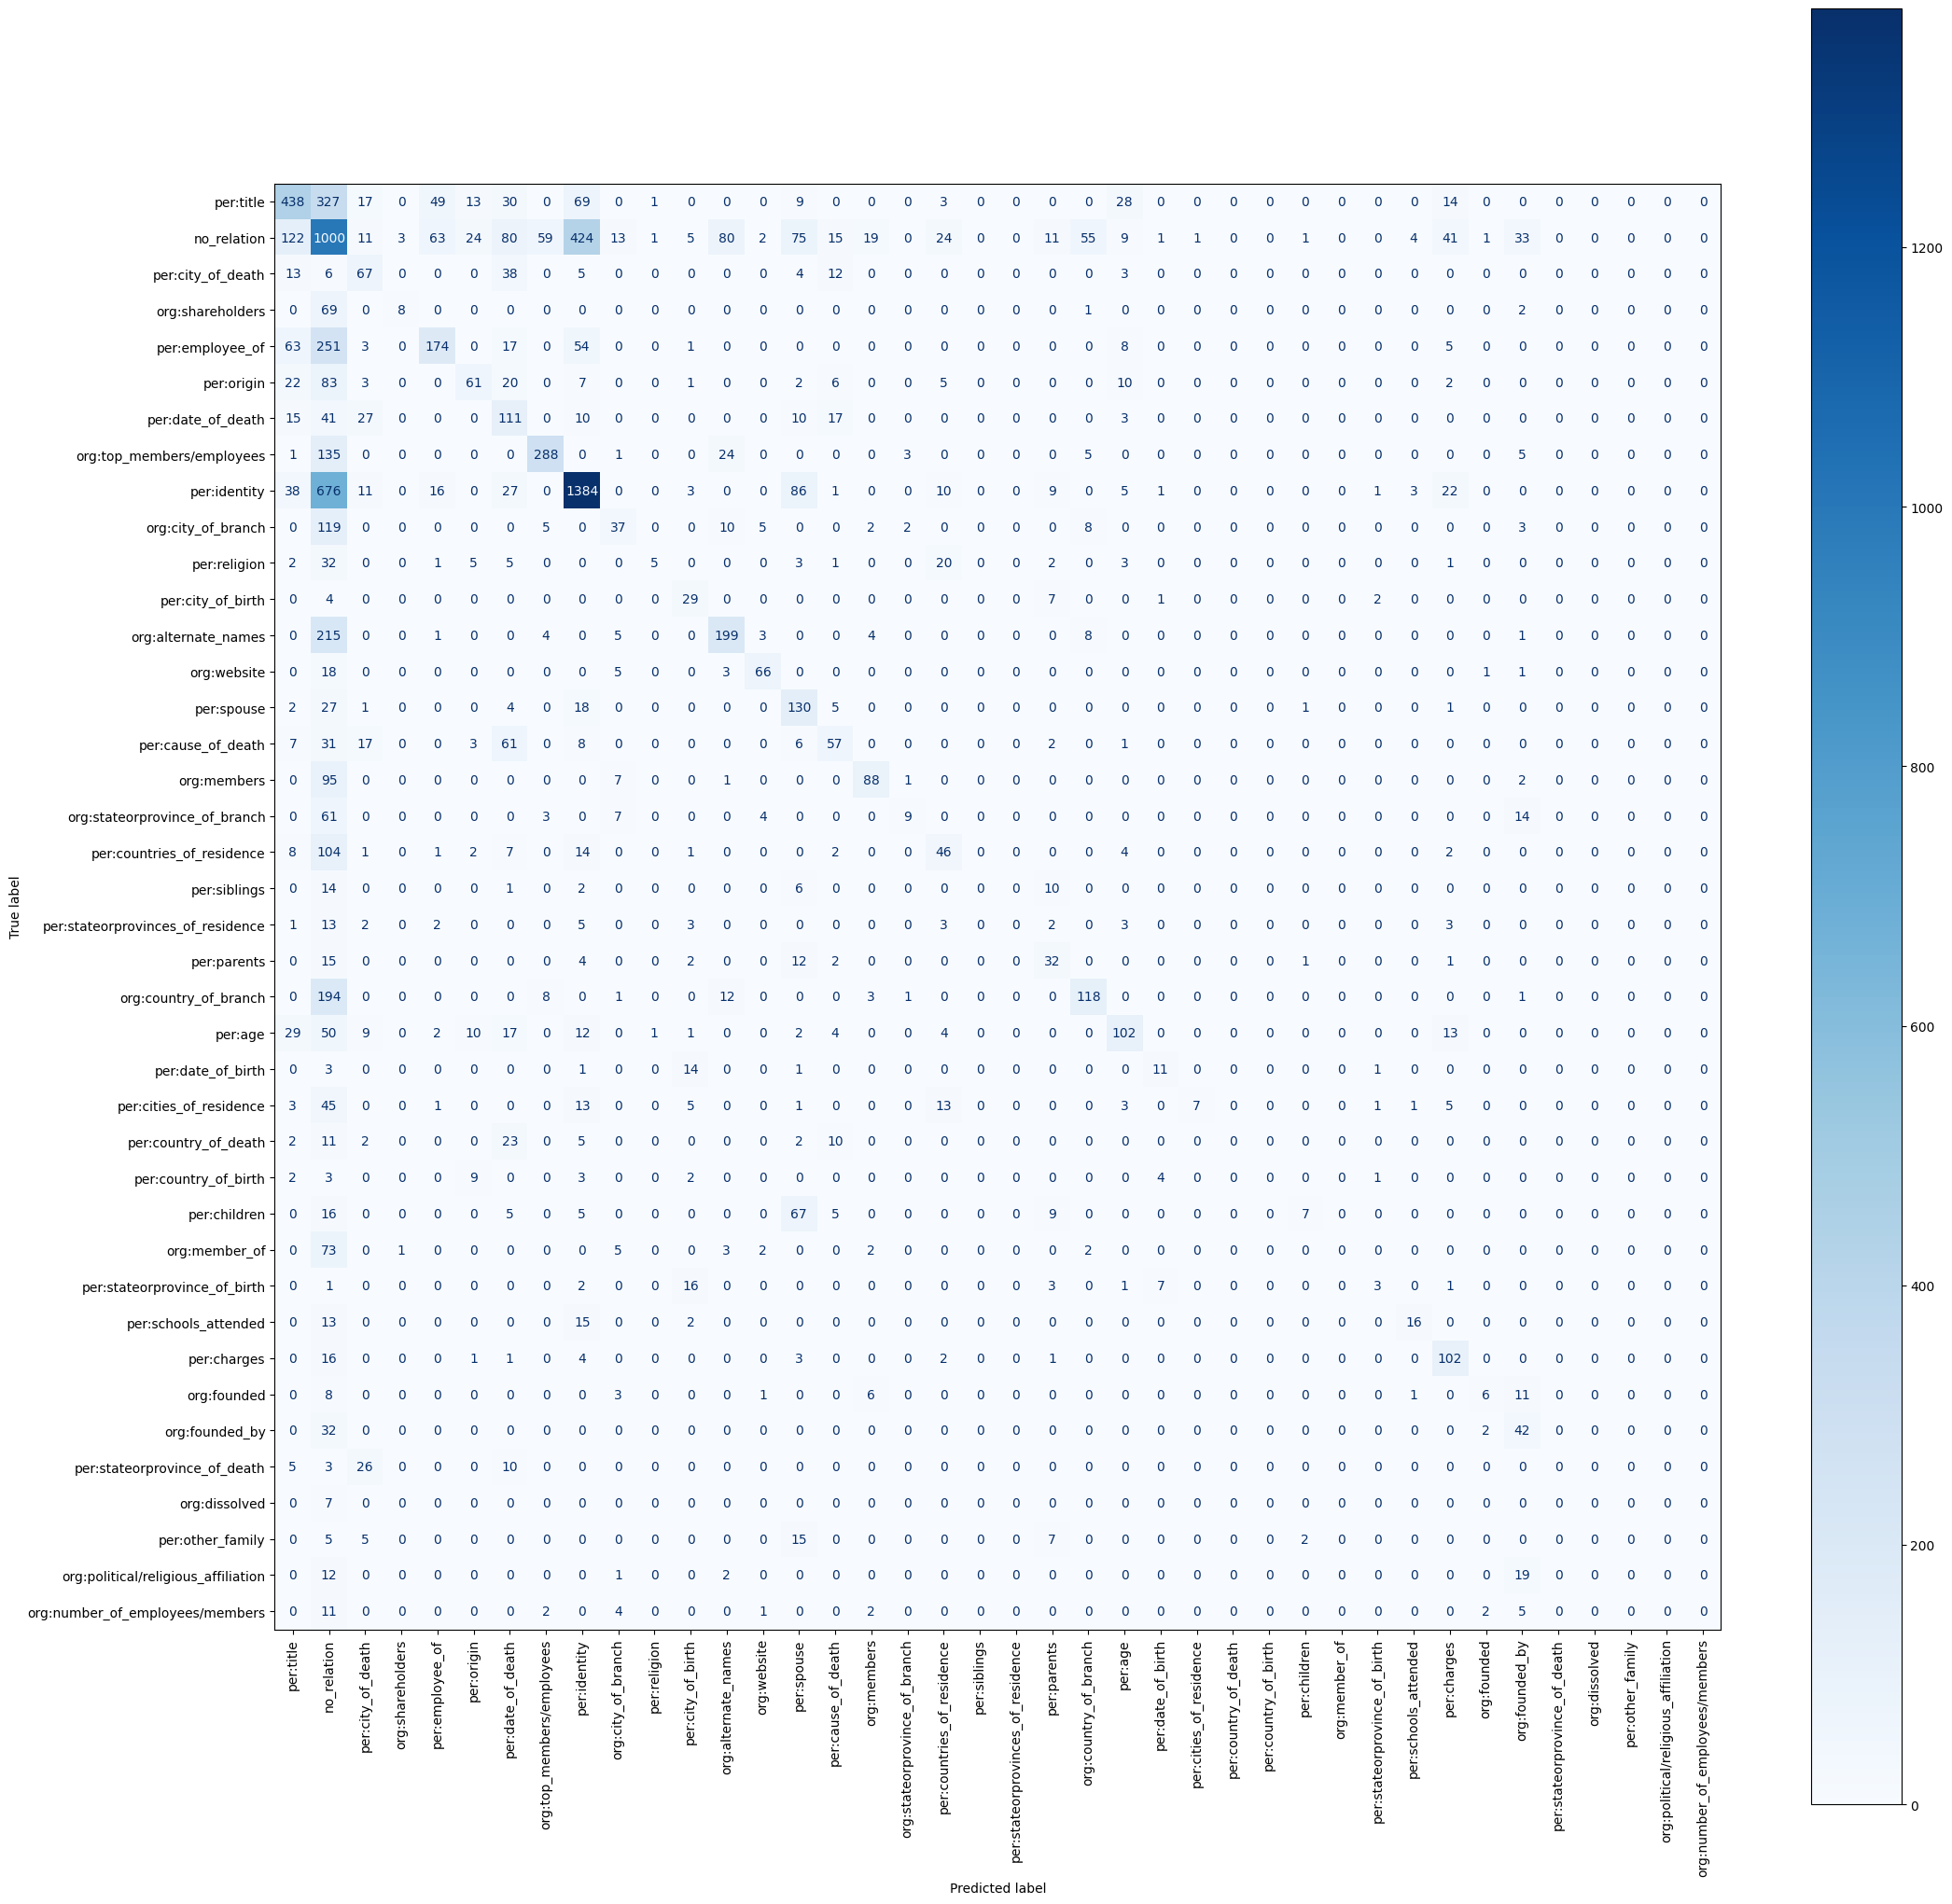

In [24]:
prediction_probs = model.predict(X)
predictions = tf.argmax(prediction_probs, axis=1)
y_index = tf.argmax(y, axis=1)

cm = confusion_matrix(y_index, predictions)

fig, ax = plt.subplots(figsize=(25, 25), dpi=100)
dis = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
dis.plot(ax=ax, im_kw={"interpolation": "nearest", "cmap": plt.cm.Blues}, xticks_rotation="vertical")
plt.show()
# print(classification_report(y_index, predictions, digits=3))